In [1]:
# implement value iteration for 6 x 6 gridworld
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [11]:
# GridWorld6x6 class
# arguments :
# rmat : 6x6 matrix specifying rewards for each 36 states
# p : p(s'|s,a) probability of choosing action a. Default = 0.8
# gamma : discount factor. Default = 0.9
# eps : threshold to stop. Default = 0.001

class GridWorld6x6:
    def __init__(self,rmat= np.zeros((6,6)),mask = np.ones((6,6)),terminal = np.zeros((6,6)), p=0.8,gamma=0.9,eps=0.001):
        self.rmat = rmat
        self.mask = mask
        self.terminal = terminal
        self.vmat = np.zeros((6,6)) # value intialized to zero
        self.vmat_e = np.zeros((8,8))
        self.pimat = np.zeros((6,6)) #0=NORTH,1=EAST,2=SOUTH,3=WEST
        self.p = p # prob of intended policy
        self.pe = 0.5*(1-p) # prob that it wanders in undesired direction
        self.gamma = gamma
        self.eps = eps
        self.iter = 0
    # def setreward(self,row,col,val): # assign reward to a state (grid). First state is (0,0)
    #     self.rmat[row,col] = val
    # def setobstacle(self,row,col): # specify an obstacle grid
    #     self.mask[row,col] = 0
    # def setterminal(self,row,col): # specify a terminal grid
    #     self.terminal[row,col] = 1
    def setgrid(self, rmat, mask, terminal): # set all matrices
        self.rmat = rmat
        self.mask = mask
        self.terminal = terminal

    
    def setp(self,p):
        self.p = p
    def setgamma(self,gamma):
        self.gamma = gamma
    def seteps(self, eps):
        self.eps = eps
    def getvmat(self):
        return np.round(self.vmat,2)
    def getpimat(self):
        return self.pimat
    def evalpi(self): # evaluate optimal policy
        # 0 = NORTH, 1 = EAST, 2 = SOUTH, 3 = WEST
        # augment edge of -inf to ease argmax() operation
        hedge = np.array([[-np.inf],[-np.inf],[-np.inf],[-np.inf],[-np.inf],[-np.inf]])
        self.vmat_e =  np.hstack((hedge,self.vmat,hedge))
        vedge = np.array([-np.inf,-np.inf,-np.inf,-np.inf,-np.inf,-np.inf,-np.inf,-np.inf])
        self.vmat_e = np.vstack((vedge,self.vmat_e,vedge))
        for i in range(6):
            for j in range(6):
                if not self.mask[i,j]: #  an obstacle grid
                    self.vmat_e[i+1,j+1] = -np.inf
        for i in range(1,7):
            for j in range(1,7):
                if self.mask[i-1,j-1]: # not an obstacle grid
                    v_north = self.vmat_e[i-1,j]
                    v_east = self.vmat_e[i,j+1]
                    v_south = self.vmat_e[i+1,j]
                    v_west = self.vmat_e[i,j-1]
                    a = np.argmax([v_north,v_east,v_south,v_west])
                    self.pimat[i-1,j-1] = a
                else: # obstacle
                    self.pimat[i-1,j-1] = -100
                if self.terminal[i-1,j-1]>0: # a positive terminal grid
                    self.pimat[i-1,j-1] = 10
                elif self.terminal[i-1,j-1]<0: # a negative terminal grid
                    self.pimat[i-1,j-1] = -10
        return self.pimat

    def solve(self):
        # self.iter = 0
        while self.iter<1000:
            self.step()
            # self.iter+=1
            #print(self.vmat)
            #print("Norm = "+str(np.linalg.norm(self.vmat - vmat1)))
            if np.linalg.norm(self.vmat - self.vmat1)<self.eps: 
                break
        print("Value iteration finishes at {} iterations".format(self.iter))
        return self.vmat                        
        
    def step(self):  # one step of dynamic programming of gridworld. Use in-place method
        # values correspoinding to x1 = NORTH, x2 = EAST, x3 = SOUTH, x4 = WEST
        # iter = 0
        # while iter<1000:
        self.vmat1 = self.vmat.copy() 
        for i in range(6):
            for j in range(6):
                if self.mask[i,j] and not self.terminal[i,j]:  # not an obstacle grid nor a terminal grid
                    # case 1: NORTH obstacle only
                    if (i==0 or self.mask[i-1,j]==0) \
                    and not (j==5 or self.mask[i,j+1]==0) \
                    and not (i==5 or self.mask[i+1,j]==0) \
                    and not (j==0 or self.mask[i,j-1]==0): 
                        x1 = (self.p*self.vmat[i,j] + self.pe*self.vmat[i,j+1] + 
                              self.pe*self.vmat[i,j-1]) # go NORTH
                        x2 = (self.p*self.vmat[i,j+1]+self.pe*self.vmat[i,j] + 
                              self.pe*self.vmat[i+1,j]) # go EAST
                        x3 = (self.p*self.vmat[i+1,j]+self.pe*self.vmat[i,j+1] + 
                              self.pe*self.vmat[i,j-1]) # go SOUTH
                        x4 = (self.p*self.vmat[i,j-1]+self.pe*self.vmat[i,j]+
                              self.pe*self.vmat[i+1,j]) # go WEST
                    # case 2: NORTH and EAST obstacles
                    elif (i==0 or self.mask[i-1,j]==0) \
                    and (j==5 or self.mask[i,j+1]==0) \
                    and not (i==5 or self.mask[i+1,j]==0) \
                    and not (j==0 or self.mask[i,j-1]==0): 
                        x1 = (self.p*self.vmat[i,j] + self.pe*self.vmat[i,j] + 
                              self.pe*self.vmat[i,j-1]) # go NORTH
                        x2 = (self.p*self.vmat[i,j]+self.pe*self.vmat[i,j] + 
                              self.pe*self.vmat[i+1,j]) # go EAST
                        x3 = (self.p*self.vmat[i+1,j]+self.pe*self.vmat[i,j] + 
                              self.pe*self.vmat[i,j-1]) # go SOUTH
                        x4 = (self.p*self.vmat[i,j-1]+self.pe*self.vmat[i,j]+
                              self.pe*self.vmat[i+1,j]) # go WEST                       
                    # case 3: NORTH and SOUTH obstacles
                    elif (i==0 or self.mask[i-1,j]==0) \
                    and not (j==5 or self.mask[i,j+1]==0) \
                    and (i==5 or self.mask[i+1,j]==0) \
                    and not (j==0 or self.mask[i,j-1]==0): 
                        x1 = (self.p*self.vmat[i,j] + self.pe*self.vmat[i,j+1] + 
                              self.pe*self.vmat[i,j-1]) # go NORTH
                        x2 = (self.p*self.vmat[i,j+1]+self.pe*self.vmat[i,j] + 
                              self.pe*self.vmat[i,j]) # go EAST
                        x3 = (self.p*self.vmat[i,j]+self.pe*self.vmat[i,j+1] + 
                              self.pe*self.vmat[i,j-1]) # go SOUTH
                        x4 = (self.p*self.vmat[i,j-1]+self.pe*self.vmat[i,j]+
                              self.pe*self.vmat[i,j]) # go WEST
                    # case 4: NORTH and WEST obstacles
                    elif (i==0 or self.mask[i-1,j]==0) \
                    and not (j==5 or self.mask[i,j+1]==0) \
                    and not (i==5 or self.mask[i+1,j]==0) \
                    and (j==0 or self.mask[i,j-1]==0): 
                        x1 = (self.p*self.vmat[i,j] + self.pe*self.vmat[i,j+1] + 
                              self.pe*self.vmat[i,j]) # go NORTH
                        x2 = (self.p*self.vmat[i,j+1]+self.pe*self.vmat[i,j] + 
                              self.pe*self.vmat[i+1,j]) # go EAST
                        x3 = (self.p*self.vmat[i+1,j]+self.pe*self.vmat[i,j+1] + 
                              self.pe*self.vmat[i,j]) # go SOUTH
                        x4 = (self.p*self.vmat[i,j]+self.pe*self.vmat[i,j]+
                              self.pe*self.vmat[i+1,j]) # go WEST
                    # case 5: EAST obstacle only
                    elif (j==5 or self.mask[i,j+1]==0) \
                    and not (i==0 or self.mask[i-1,j]==0) \
                    and not (i==5 or self.mask[i+1,j]==0) \
                    and not (j==0 or self.mask[i,j-1]==0): 
                        x1 = (self.p*self.vmat[i-1,j] + self.pe*self.vmat[i,j-1] + 
                              self.pe*self.vmat[i,j]) # go NORTH
                        x2 = (self.p*self.vmat[i,j]+self.pe*self.vmat[i-1,j] + 
                              self.pe*self.vmat[i+1,j]) # go EAST
                        x3 = (self.p*self.vmat[i+1,j]+self.pe*self.vmat[i,j-1] + 
                              self.pe*self.vmat[i,j]) # go SOUTH
                        x4 = (self.p*self.vmat[i,j-1]+self.pe*self.vmat[i-1,j]+
                              self.pe*self.vmat[i+1,j]) # go WEST
                    # case 6: EAST and SOUTH obstacles
                    elif (j==5 or self.mask[i,j+1]==0) \
                    and not (i==0 or self.mask[i-1,j]==0) \
                    and (i==5 or self.mask[i+1,j]==0) \
                    and not (j==0 or self.mask[i,j-1]==0): 
                        x1 = (self.p*self.vmat[i-1,j] + self.pe*self.vmat[i,j-1] + 
                              self.pe*self.vmat[i,j]) # go NORTH
                        x2 = (self.p*self.vmat[i,j]+self.pe*self.vmat[i-1,j] + 
                              self.pe*self.vmat[i,j]) # go EAST
                        x3 = (self.p*self.vmat[i,j]+self.pe*self.vmat[i,j-1] + 
                              self.pe*self.vmat[i,j]) # go SOUTH
                        x4 = (self.p*self.vmat[i,j-1]+self.pe*self.vmat[i-1,j]+
                              self.pe*self.vmat[i,j]) # go WEST
                    # case 7: EAST and WEST obstacles
                    elif (j==5 or self.mask[i,j+1]==0) \
                    and not (i==0 or self.mask[i-1,j]==0) \
                    and not (i==5 or self.mask[i+1,j]==0) \
                    and (j==0 or self.mask[i,j-1]==0): 
                        x1 = (self.p*self.vmat[i-1,j] + self.pe*self.vmat[i,j] + 
                              self.pe*self.vmat[i,j]) # go NORTH
                        x2 = (self.p*self.vmat[i,j]+self.pe*self.vmat[i-1,j] + 
                              self.pe*self.vmat[i+1,j]) # go EAST
                        x3 = (self.p*self.vmat[i+1,j]+self.pe*self.vmat[i,j] + 
                              self.pe*self.vmat[i,j]) # go SOUTH
                        x4 = (self.p*self.vmat[i,j]+self.pe*self.vmat[i-1,j]+
                              self.pe*self.vmat[i+1,j]) # go WEST
                    # case 8: SOUTH obstacle only
                    elif (i==5 or self.mask[i+1,j]==0) \
                    and not (i==0 or self.mask[i-1,j]==0) \
                    and not (j==5 or self.mask[i,j+1]==0) \
                    and not (j==0 or self.mask[i,j-1]==0): 
                        x1 = (self.p*self.vmat[i-1,j] + self.pe*self.vmat[i,j+1] + 
                              self.pe*self.vmat[i,j-1]) # go NORTH
                        x2 = (self.p*self.vmat[i,j+1]+self.pe*self.vmat[i-1,j] + 
                              self.pe*self.vmat[i,j]) # go EAST
                        x3 = (self.p*self.vmat[i,j]+self.pe*self.vmat[i,j+1] + 
                              self.pe*self.vmat[i,j-1]) # go SOUTH
                        x4 = (self.p*self.vmat[i,j-1]+self.pe*self.vmat[i-1,j]+
                              self.pe*self.vmat[i,j]) # go WEST
                    # case 9: SOUTH and WEST obstacles
                    elif (i==5 or self.mask[i+1,j]==0) \
                    and not (i==0 or self.mask[i-1,j]==0) \
                    and not (j==5 or self.mask[i,j+1]==0) \
                    and (j==0 or self.mask[i,j-1]==0): 
                        x1 = (self.p*self.vmat[i-1,j] + self.pe*self.vmat[i,j+1] + 
                              self.pe*self.vmat[i,j]) # go NORTH
                        x2 = (self.p*self.vmat[i,j+1]+self.pe*self.vmat[i-1,j] + 
                              self.pe*self.vmat[i,j]) # go EAST
                        x3 = (self.p*self.vmat[i,j]+self.pe*self.vmat[i,j+1] + 
                              self.pe*self.vmat[i,j]) # go SOUTH
                        x4 = (self.p*self.vmat[i,j]+self.pe*self.vmat[i-1,j]+
                              self.pe*self.vmat[i,j]) # go WEST
                    # case 10: WEST obstacle only
                    elif (j==0 or self.mask[i,j-1]==0) \
                    and not (i==0 or self.mask[i-1,j]==0) \
                    and not (j==5 or self.mask[i,j+1]==0) \
                    and not (i==5 or self.mask[i+1,j]==0): 
                        x1 = (self.p*self.vmat[i-1,j] + self.pe*self.vmat[i,j+1] + 
                              self.pe*self.vmat[i,j]) # go NORTH
                        x2 = (self.p*self.vmat[i,j+1]+self.pe*self.vmat[i-1,j] + 
                              self.pe*self.vmat[i+1,j]) # go EAST
                        x3 = (self.p*self.vmat[i+1,j]+self.pe*self.vmat[i,j+1] + 
                              self.pe*self.vmat[i,j]) # go SOUTH
                        x4 = (self.p*self.vmat[i,j]+self.pe*self.vmat[i-1,j]+
                              self.pe*self.vmat[i+1,j]) # go WEST
                    # case 11: NORTH, EAST, SOUTH obstacles
                    elif (i==0 or self.mask[i-1,j]==0) \
                    and not (j==0 or self.mask[i,j-1]==0) \
                    and (j==5 or self.mask[i,j+1]==0) \
                    and (i==5 or self.mask[i+1,j]==0): 
                        x1 = (self.p*self.vmat[i,j] + self.pe*self.vmat[i,j] + 
                              self.pe*self.vmat[i,j-1]) # go NORTH
                        x2 = (self.p*self.vmat[i,j]+self.pe*self.vmat[i,j] + 
                              self.pe*self.vmat[i,j]) # go EAST
                        x3 = (self.p*self.vmat[i,j]+self.pe*self.vmat[i,j-1] + 
                              self.pe*self.vmat[i,j]) # go SOUTH
                        x4 = (self.p*self.vmat[i,j-1]+self.pe*self.vmat[i,j]+
                              self.pe*self.vmat[i,j]) # go WEST
                    # case 12: NORTH, EAST, WEST obstacles
                    elif (i==0 or self.mask[i-1,j]==0) \
                    and (j==0 or self.mask[i,j-1]==0) \
                    and (j==5 or self.mask[i,j+1]==0) \
                    and not (i==5 or self.mask[i+1,j]==0): 
                        x1 = (self.p*self.vmat[i,j] + self.pe*self.vmat[i,j] + 
                              self.pe*self.vmat[i,j]) # go NORTH
                        x2 = (self.p*self.vmat[i,j]+self.pe*self.vmat[i,j] + 
                              self.pe*self.vmat[i+1,j]) # go EAST
                        x3 = (self.p*self.vmat[i+1,j]+self.pe*self.vmat[i,j] + 
                              self.pe*self.vmat[i,j]) # go SOUTH
                        x4 = (self.p*self.vmat[i,j]+self.pe*self.vmat[i,j]+
                              self.pe*self.vmat[i+1,j]) # go WEST
                    # case 13: NORTH, SOUTH, WEST obstacles
                    elif (i==0 or self.mask[i-1,j]==0) \
                    and (j==0 or self.mask[i,j-1]==0) \
                    and not (j==5 or self.mask[i,j+1]==0) \
                    and (i==5 or self.mask[i+1,j]==0): 
                        x1 = (self.p*self.vmat[i,j] + self.pe*self.vmat[i,j+1] + 
                              self.pe*self.vmat[i,j]) # go NORTH
                        x2 = (self.p*self.vmat[i,j+1]+self.pe*self.vmat[i,j] + 
                              self.pe*self.vmat[i,j]) # go EAST
                        x3 = (self.p*self.vmat[i,j]+self.pe*self.vmat[i,j+1] + 
                              self.pe*self.vmat[i,j]) # go SOUTH
                        x4 = (self.p*self.vmat[i,j]+self.pe*self.vmat[i,j]+
                              self.pe*self.vmat[i,j]) # go WEST
                    # case 14: EAST, SOUTH, WEST obstacles
                    elif (i==5 or self.mask[i+1,j]==0) \
                    and (j==0 or self.mask[i,j-1]==0) \
                    and (j==5 or self.mask[i,j+1]==0) \
                    and not (i==0 or self.mask[i-1,j]==0): 
                        x1 = (self.p*self.vmat[i-1,j] + self.pe*self.vmat[i,j] + 
                              self.pe*self.vmat[i,j]) # go NORTH
                        x2 = (self.p*self.vmat[i,j]+self.pe*self.vmat[i-1,j] + 
                              self.pe*self.vmat[i,j]) # go EAST
                        x3 = (self.p*self.vmat[i,j]+self.pe*self.vmat[i,j] + 
                              self.pe*self.vmat[i,j]) # go SOUTH
                        x4 = (self.p*self.vmat[i,j]+self.pe*self.vmat[i-1,j]+
                              self.pe*self.vmat[i,j]) # go WEST
                    # case 15: NORTH,EAST, SOUTH, WEST obstacles. Absurd case, but need to have it
                    # to make things work properly
                    elif (i==5 or self.mask[i+1,j]==0) \
                    and (j==0 or self.mask[i,j-1]==0) \
                    and (j==5 or self.mask[i,j+1]==0) \
                    and (i==0 or self.mask[i-1,j]==0): 
                        x1 = x2 = x3 = x4 = self.vmat[i,j] # every direccion bounces back
                    else: # no obstacle
                        x1 = (self.p*self.vmat[i-1,j] + self.pe*self.vmat[i,j-1] + 
                              self.pe*self.vmat[i,j+1]) # go NORTH
                        x2 = (self.p*self.vmat[i,j+1]+self.pe*self.vmat[i-1,j] + 
                              self.pe*self.vmat[i+1,j]) # go EAST
                        x3 = (self.p*self.vmat[i+1,j]+self.pe*self.vmat[i,j+1] + 
                              self.pe*self.vmat[i,j-1]) # go SOUTH
                        x4 = (self.p*self.vmat[i,j-1]+self.pe*self.vmat[i-1,j]+
                              self.pe*self.vmat[i+1,j]) # go WEST
                    self.vmat[i,j]=self.rmat[i,j]+self.gamma*max(x1,x2,x3,x4)
                
                if self.terminal[i,j]:  # terminal states require special handling
                    # print("i = {}, j = {} is a terminal state".format(i,j))
                    self.vmat[i,j] = self.rmat[i,j] # value of terminal state just equal to reward
                    # print("vmat[i,j] set to {}".format(self.vmat[i,j]))
        #print("Iteration "  + str(iter))
        self.iter+=1
        return self.vmat
                        
                        


In [3]:
def solvenplotvi(rmat,mask,terminal, p=0.8,gamma=0.9,eps=0.001):
    gw = GridWorld6x6(rmat=rmat,mask=mask,terminal=terminal,p=p,gamma=gamma)
    vmat = gw.solve()
    pimat = gw.evalpi()
    offset = 0.1
    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_aspect('equal')
    ax.set_xlim(-3.0,3.0)
    ax.set_ylim(-3.0,3.0)   
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.grid(True)
    grid_center_x = np.array([-2.5,-1.5,-0.5,0.5,1.5,2.5])
    grid_center_y = np.array([2.5,1.5,0.5,-0.5,-1.5,-2.5])
    grid_center_xo = grid_center_x - offset
    grid_center_yo = grid_center_y - offset
    grid_width = 1.0
    grid_height = 1.0
    # show obstacle
    for i in range(6):
        for j in range(6):
            llx = grid_center_x[j]-0.5*grid_width
            lly = grid_center_y[i]-0.5*grid_height
            if not mask[i,j]:
                #print("Plot obstacle at {},{}".format(llx,lly))
                ax.add_patch(Rectangle((llx,lly),grid_width,grid_height,color='gray'))
            if terminal[i,j]:
                if rmat[i,j] > 0:
                    ax.add_patch(Rectangle((llx,lly),grid_width,grid_height,color='green'))
                    plt.text(grid_center_xo[j],grid_center_yo[i],str(rmat[i,j]), fontsize = 12)
                if rmat[i,j] > 50: # precious reward
                    ax.add_patch(Rectangle((llx,lly),grid_width,grid_height,color='gold'))
                    plt.text(grid_center_xo[j],grid_center_yo[i],str(rmat[i,j]), fontsize = 12)
                if rmat[i,j] < 0: # bad reward
                    ax.add_patch(Rectangle((llx,lly),grid_width,grid_height,color='red'))
                    plt.text(grid_center_xo[j],grid_center_yo[i],str(rmat[i,j]), fontsize = 12)
            if pimat[i,j] == 0: # NORTH
                plt.text(grid_center_xo[j],grid_center_yo[i],'^', fontsize = 16)
            elif pimat[i,j] == 1: # EAST
                plt.text(grid_center_xo[j],grid_center_yo[i],'>', fontsize = 12)
            elif pimat[i,j] == 2: # SOUTH
                plt.text(grid_center_xo[j],grid_center_yo[i],'v', fontsize = 12)
            elif pimat[i,j] == 3: # WEST
                plt.text(grid_center_xo[j],grid_center_yo[i],'<', fontsize = 12)
                
    return pimat,vmat

Value iteration finishes at 20 iterations


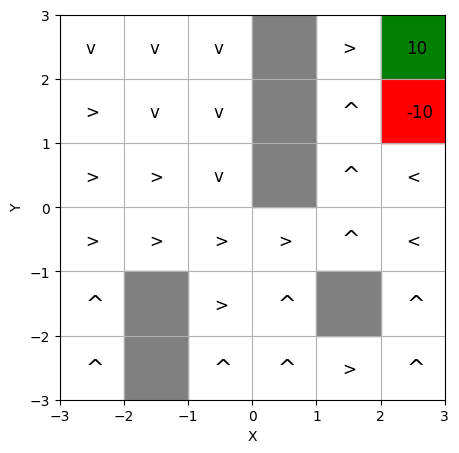

In [12]:
rmat = np.array([[0,0,0,0,0,10],[0,0,0,0,0,-10],[0,0,0,0,0,0],\
                 [0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]])
mask = np.array([[1,1,1,0,1,1],[1,1,1,0,1,1],[1,1,1,0,1,1],\
                 [1,1,1,1,1,1],[1,0,1,1,0,1],[1,0,1,1,1,1]])
terminal = np.array([[0,0,0,0,0,1],[0,0,0,0,0,-1],[0,0,0,0,0,0],\
                 [0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]])
pimat,vmat=solvenplotvi(rmat=rmat,mask=mask,terminal=terminal)

Value iteration finishes at 22 iterations


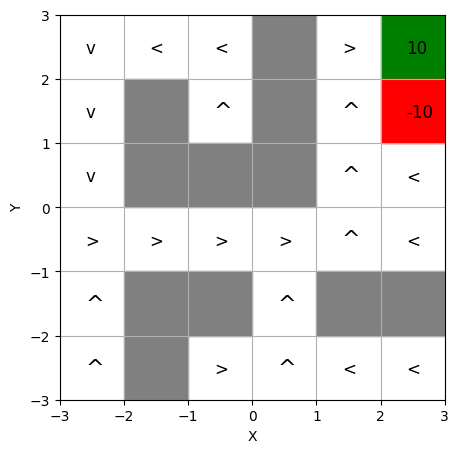

In [7]:
rmat = np.array([[0,0,0,0,0,10],[0,0,0,0,0,-10],[0,0,0,0,0,0],\
                 [0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]])
mask = np.array([[1,1,1,0,1,1],[1,0,1,0,1,1],[1,0,0,0,1,1],\
                 [1,1,1,1,1,1],[1,0,0,1,0,0],[1,0,1,1,1,1]])
terminal = np.array([[0,0,0,0,0,1],[0,0,0,0,0,-1],[0,0,0,0,0,0],\
                 [0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]])
pimat,vmat=solvenplotvi(rmat=rmat,mask=mask,terminal=terminal)

In [ ]:
### Pieter Abbeel Ex1

Value iteration finishes at 16 iterations


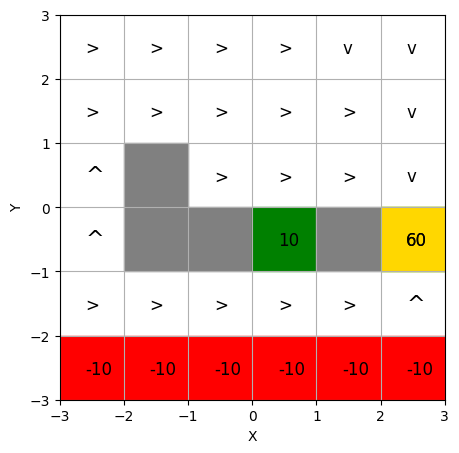

In [8]:
# gamma = 0.99, pa = 0.8 
rmat = np.array([[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],\
                 [0,0,0,10,0,60],[0,0,0,0,0,0],[-10,-10,-10,-10,-10,-10]])
mask = np.array([[1,1,1,1,1,1],[1,1,1,1,1,1],[1,0,1,1,1,1],\
                 [1,0,0,1,0,1],[1,1,1,1,1,1],[1,1,1,1,1,1]])
terminal = np.array([[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],\
                 [0,0,0,1,0,1],[0,0,0,0,0,0],[1,1,1,1,1,1]])
pimat,vmat=solvenplotvi(rmat=rmat,mask=mask,terminal=terminal,gamma=0.9,p=0.9)

In [29]:
np.round(vmat,2)

array([[ 21.51,  24.35,  27.48,  30.96,  34.81,  39.04],
       [ 22.68,  26.32,  30.22,  34.56,  39.58,  45.  ],
       [ 19.91,   0.  ,  31.79,  36.41,  45.  ,  51.92],
       [ 17.48,   0.  ,   0.  ,  10.  ,   0.  ,  60.  ],
       [ 15.43,  16.11,  21.61,  28.57,  39.68,  51.4 ],
       [-10.  , -10.  , -10.  , -10.  , -10.  , -10.  ]])

Value iteration finishes at 9 iterations


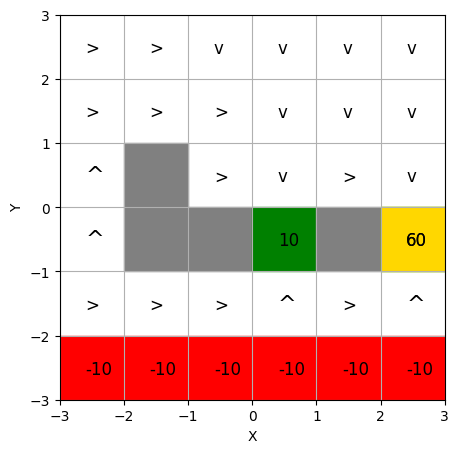

In [9]:
# gamma = 0.3, pa = 0.8
rmat = np.array([[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],\
                 [0,0,0,10,0,60],[0,0,0,0,0,0],[-10,-10,-10,-10,-10,-10]])
mask = np.array([[1,1,1,1,1,1],[1,1,1,1,1,1],[1,0,1,1,1,1],\
                 [1,0,0,1,0,1],[1,1,1,1,1,1],[1,1,1,1,1,1]])
terminal = np.array([[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],\
                 [0,0,0,1,0,1],[0,0,0,0,0,0],[1,1,1,1,1,1]])
pimat,vmat=solvenplotvi(rmat=rmat,mask=mask,terminal=terminal, gamma=0.3, p=0.8)

Value iteration finishes at 38 iterations


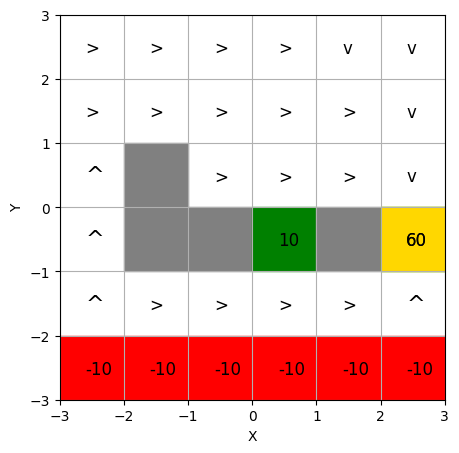

In [10]:
# gamma = 0.3, pa = 0.5
rmat = np.array([[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],\
                 [0,0,0,10,0,60],[0,0,0,0,0,0],[-10,-10,-10,-10,-10,-10]])
mask = np.array([[1,1,1,1,1,1],[1,1,1,1,1,1],[1,0,1,1,1,1],\
                 [1,0,0,1,0,1],[1,1,1,1,1,1],[1,1,1,1,1,1]])
terminal = np.array([[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],\
                 [0,0,0,1,0,1],[0,0,0,0,0,0],[1,1,1,1,1,1]])
pimat,vmat=solvenplotvi(rmat=rmat,mask=mask,terminal=terminal, gamma=0.9,p=0.5)